# Multilayer perceptron on CIFAR-10

## Imports

In [122]:
import keras
from keras.utils import np_utils
from keras.datasets import cifar10
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten
from keras.callbacks import ModelCheckpoint   
from sklearn.preprocessing import  MinMaxScaler
from sklearn.decomposition import PCA
from time import time as runtime
import sys
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

stdout = sys.stdout
sys.stdout = open('/dev/null', 'w')
sys.stdout = stdout

## Loading Data & printing shapes

In [123]:
# load the pre-shuffled train and test data
(x_train, y_train), (x_test, y_test) = cifar10.load_data()

print("trainig data shape  : ",x_train.shape)
print("trainig labels shape: ",y_train.shape)

print("testing data shape  : ",x_test.shape)
print("testing labels shape: ",y_test.shape)


# define text labels (source: https://www.cs.toronto.edu/~kriz/cifar.html)
ten = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

trainig data shape  :  (50000, 32, 32, 3)
trainig labels shape:  (50000, 1)
testing data shape  :  (10000, 32, 32, 3)
testing labels shape:  (10000, 1)


## Data exploration
First data visualisation without any pre-processing on it.
Printing 10 first images from the training set. 

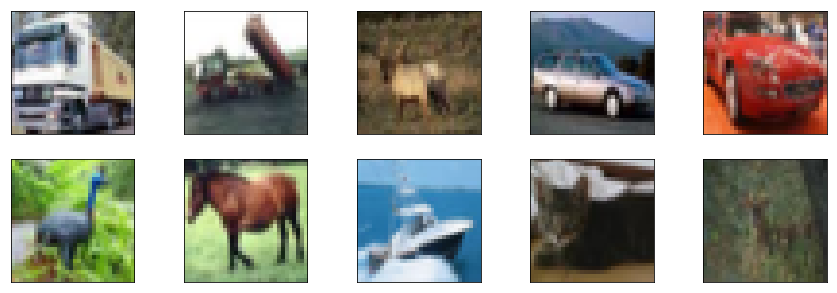

In [124]:
figure1 = plt.figure(figsize=(15,5))
aaa=x_test
for i in range(1,11):
    images = figure1.add_subplot(2, 5, i , xticks=[], yticks=[])
    images.imshow(np.squeeze(x_train[i]))

## Data normalization

In [125]:
x_train = x_train.astype('float32')/255
x_test  = x_test.astype('float32')/255

# PCA

In [126]:
x_train = x_train.reshape((50000, 3072))
x_test = x_test.reshape((10000, 3072))

#t = runtime()
pca = PCA(n_components=100)
pca.fit(x_train)


print("training PCA on training set takes: %.1f" % (runtime()-t))
t = runtime()
x_train = pca.transform(x_train)
x_test  = pca.transform(x_test)
print("Transforming training & testing set takes: %.1f" % (runtime()-t))


x_train = x_train.reshape((50000,10,10))
x_test = x_test.reshape((10000,10,10))


training PCA on training set takes: 237.9
Transforming training & testing set takes: 1.6


## Labels onehote Encoding & Spliting Testing data into training (90%) /Validation (10%) 

In [127]:
len(ten)
# encoding labels to onehot

y_train = keras.utils.to_categorical(y_train, len(ten))
y_test  = keras.utils.to_categorical(y_test, len(ten))
print("[after onehote encoding]")
print("trainig labels shape: ",y_train.shape)
print("testing labels shape: ",y_test.shape,"\n")

# training set spliting into training (45000) and validation (5000) sets
(x_train, x_validation) = x_train[5000:], x_train[:5000]
(y_train, y_validation) = y_train[5000:], y_train[:5000]

print("[after spliting]")
print("trainig   data shape  : ",x_train.shape ,x_train.shape[0], 'examples')
print("validation data shape : ",x_validation.shape," ",x_validation.shape[0],  'examples')
print("testing   data shape  : ",x_test.shape,x_test.shape[0], 'examples')


[after onehote encoding]
trainig labels shape:  (50000, 10)
testing labels shape:  (10000, 10) 

[after spliting]
trainig   data shape  :  (45000, 10, 10) 45000 examples
validation data shape :  (5000, 10, 10)   5000 examples
testing   data shape  :  (10000, 10, 10) 10000 examples


# MLP: Multilayer Perceptron Definition
https://keras.io/getting-started/sequential-model-guide/

In [128]:
#creating a sequential model &passing a list of layers instances to it

MLP = Sequential([ Flatten(input_shape = x_train.shape[1:]),
                   Dense(1000, activation='relu'),#a fully-connected layer with 1000 hidden units
                   Dropout(0.6),                  #helps prevent overfitting.
                   Dense(512, activation='relu'), #a fully-connected layer with 512 hidden units
                   Dropout(0.6),                  #helps prevent overfitting
                   Dense(len(ten), activation='softmax')])#a fully-connected layer with 10 hidden units
MLP.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_8 (Flatten)          (None, 100)               0         
_________________________________________________________________
dense_22 (Dense)             (None, 1000)              101000    
_________________________________________________________________
dropout_15 (Dropout)         (None, 1000)              0         
_________________________________________________________________
dense_23 (Dense)             (None, 512)               512512    
_________________________________________________________________
dropout_16 (Dropout)         (None, 512)               0         
_________________________________________________________________
dense_24 (Dense)             (None, 10)                5130      
Total params: 618,642
Trainable params: 618,642
Non-trainable params: 0
_________________________________________________________________


# MLP: Compiling the model

In [129]:
MLP.compile(loss='categorical_crossentropy', optimizer='rmsprop', metrics=['accuracy'])

# Training our MLP

In [130]:
t=runtime()
checkpointer = ModelCheckpoint(filepath='MLP.weights.best.hdf5', verbose=1, 
                               save_best_only=True)
History = MLP.fit(x_train, y_train, batch_size=200, epochs=20,
          validation_data=(x_validation, y_validation), callbacks=[checkpointer], 
          verbose=2, shuffle=True)
print("fitting the model took: %.1fs" % (runtime()-t))


Train on 45000 samples, validate on 5000 samples
Epoch 1/20
 - 9s - loss: 1.8834 - acc: 0.3334 - val_loss: 1.5998 - val_acc: 0.4430

Epoch 00001: val_loss improved from inf to 1.59976, saving model to MLP.weights.best.hdf5
Epoch 2/20
 - 6s - loss: 1.6700 - acc: 0.4092 - val_loss: 1.5165 - val_acc: 0.4796

Epoch 00002: val_loss improved from 1.59976 to 1.51648, saving model to MLP.weights.best.hdf5
Epoch 3/20
 - 6s - loss: 1.5787 - acc: 0.4404 - val_loss: 1.4498 - val_acc: 0.5004

Epoch 00003: val_loss improved from 1.51648 to 1.44979, saving model to MLP.weights.best.hdf5
Epoch 4/20
 - 8s - loss: 1.5226 - acc: 0.4616 - val_loss: 1.3933 - val_acc: 0.5190

Epoch 00004: val_loss improved from 1.44979 to 1.39325, saving model to MLP.weights.best.hdf5
Epoch 5/20
 - 7s - loss: 1.4781 - acc: 0.4776 - val_loss: 1.3806 - val_acc: 0.5258

Epoch 00005: val_loss improved from 1.39325 to 1.38058, saving model to MLP.weights.best.hdf5
Epoch 6/20
 - 6s - loss: 1.4418 - acc: 0.4894 - val_loss: 1.3505 

# MLP: Model Evaluat. with the weights that gaving best validat. accuracy

In [131]:
#model saved to 'MLP.weights.best.hdf5'
MLP.load_weights('MLP.weights.best.hdf5')
loss,test_accuracy = MLP.evaluate(x_test, y_test)
print('\n', 'Loss value' ,loss)
print('\n', 'Testing Accuracy' ,test_accuracy)

10000/10000 [==============================] - 1s 87us/step

 Loss value 1.2211069551467895

 Testing Accuracy 0.5763


In [132]:
# get predictions on the test set
y_pred = MLP.predict(x_test)


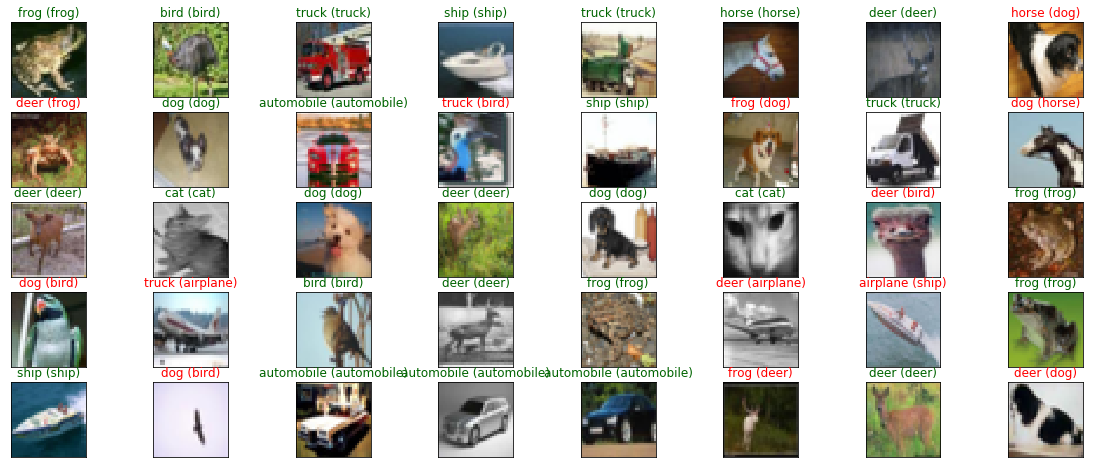

In [133]:
figure = plt.figure(figsize=(20, 8))
for i, x in enumerate(np.random.choice(10000, size=40)):
    img = figure.add_subplot(5, 8, i + 1, xticks=[], yticks=[])
    img.imshow(np.squeeze(aaa[x]))
    pred_id = np.argmax(y_pred[x])
    true_id = np.argmax(y_test[x])
    img.set_title("{} ({})".format(ten[pred_id], ten[true_id]),color=("darkgreen" if pred_id == true_id else "red"))

# MLP: Prediction Visualisation

# Visualisation

10000/10000 [==============================] - 1s 90us/step

 Loss value 1.2211069551467895

 Testing Accuracy 0.5763


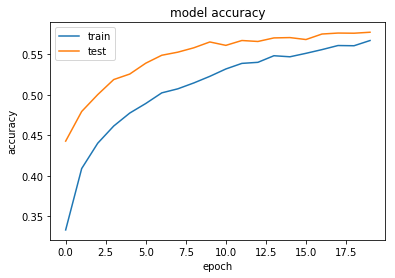

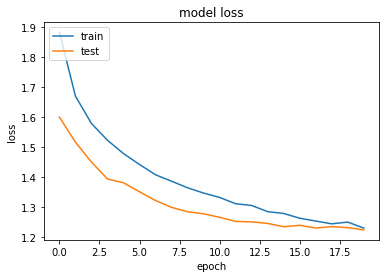

In [134]:
#model saved to 'MLP.weights.best.hdf5'
MLP.load_weights('MLP.weights.best.hdf5')
loss,test_accuracy = MLP.evaluate(x_test, y_test)
print('\n', 'Loss value' ,loss)
print('\n', 'Testing Accuracy' ,test_accuracy)

# summarize history for accuracy
plt.plot(History.history['acc'])
plt.plot(History.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(History.history['loss'])
plt.plot(History.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

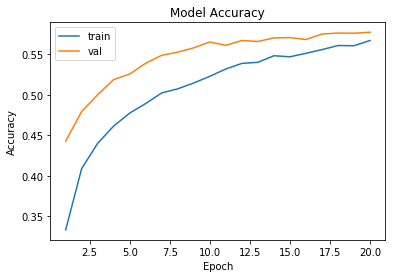

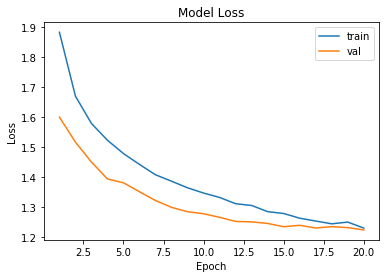

In [135]:
accuracy_length = len(History.history['acc']) 
length_val_accuracy = len(History.history['val_acc'])
loss_length = len(History.history['loss'])
length_val_accuracy = len(History.history['val_loss'])

# Visualize the reults
#fig, axs = plt.subplots(1, 2, figsize=(15, 5))

# Accuracy during training
plt.plot(range(1, accuracy_length + 1), History.history['acc'])
plt.plot(range(1, length_val_accuracy + 1), History.history['val_acc'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['train', 'val'], loc='best')
plt.show()
# Loss during training
plt.plot(range(1, loss_length +1), History.history['loss'])
plt.plot(range(1, length_val_accuracy +1), History.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['train', 'val'], loc='best')
plt.show()